# Import Library

In [ ]:

import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize

# SenticNet for Emotion Features
from senticnet.senticnet import SenticNet

# Deep Learning
from gensim.models import FastText
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Evaluation Metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc, make_scorer,roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

# Data Preparation

In [ ]:
file_path = r".\Pre_Hate_Dataset\UnseenData_ForTestSetUsed.csv"

data = pd.read_csv(file_path)
X = data['text'].astype(str).values  
Y = data['label'].values  
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

# Train test Split
X_train_orig, X_test_orig, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=42)

max_words = 20000  
max_len = 100  

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_orig)

# Hate Text (text for get hate speech feature)
X_train_seq = tokenizer.texts_to_sequences(X_train_orig)
X_test_seq = tokenizer.texts_to_sequences(X_test_orig)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Undersampling: 
    # Since the two data forms are different, use indices undersampling method and apply it to X_train_pad and X_train_orig
undersampler = RandomUnderSampler(random_state=42)
    # Generate dummy 2D indices [[0], [1], [2], ...] because fit_resample() requires 2D input
    # np.arange(len(Y_train)) creates [0, 1, 2, ..., n-1] (indices of all samples)
    # RandomUnderSampler require input 2D shape(n_samples, 1). 
    # reshape(-1, 1) converts 1D [1,2,3,4] to 2D shape [[1], [2], [3], [4], [5]]
dummy_indices = np.arange(len(Y_train)).reshape(-1, 1)
train_indices_resampled, Y_train_resampled = undersampler.fit_resample(dummy_indices, Y_train)
    # Apply the undersampled indices to X_train_pad (padded sequences) for hate speech feature extraction
    # .flatten() converts [[5], [89], [79], ...] to [5, 89, 79, ...] 
X_train_resampled = X_train_pad[train_indices_resampled.flatten()]
# Apply the same indices to X_train_orig (original text) for SenticNet feature extraction
# SenticNet requires raw text input, not numerical sequences
X_train_senticnet_resampled = [X_train_orig[i] for i in train_indices_resampled.flatten()]

# SenticNet Feature Extraction
def extract_sentic_features(text, tokenizer, max_length):
    sn = SenticNet()
    num_sentic_features = 24  # 24-dimensional features provided by SenticNet
    sentic_matrix = np.zeros((max_length, num_sentic_features), dtype=np.float32)

    tokens = word_tokenize(text) 
    token_indices = tokenizer.texts_to_sequences([tokens])[0] # Convert to index (exp: [4, 10, 7])
    
    for i, token_idx in enumerate(token_indices[:max_length]):
        word = tokenizer.index_word.get(token_idx, '') # Reverse search for a word based on the index (exp: 4 → "I")
        try:
            # sn.concept(word): Query the sentiment features of word word in SenticNet
            sentic_values = [float(sn.concept(word)[j]) for j in range(num_sentic_features)]
            sentic_matrix[i] = sentic_values
        except KeyError:
            pass  # If SenticNet does not have the feature of this word, write 0
    return sentic_matrix

def batch_extract_sentic(texts, tokenizer, max_length):
    sentic_features = np.array([extract_sentic_features(text, tokenizer, max_length) for text in texts])
    return sentic_features.astype(np.float32)

x_train_sentic = batch_extract_sentic(X_train_senticnet_resampled, tokenizer, max_len)
x_test_sentic = batch_extract_sentic(X_test_orig, tokenizer, max_len)

# # Align dimensions between word indices (X_train_resampled) and SenticNet features (x_train_sentic)
# # Both need to be 3D shape: [num_samples, sequence_length, num_features] to concatenate the hate speech feature with emotion feature
#     # Add singleton dimension (changes [samples, length] to [samples, length, 1])
# X_train_resampled = np.expand_dims(X_train_resampled, axis=-1).astype(np.float32)
# X_test_pad = np.expand_dims(X_test_pad, axis=-1).astype(np.float32)
#     # Change [samples, length, 1] to  [samples, length, 24] 
# X_train_resampled = np.tile(X_train_resampled, (1, 1, 24))
# X_test_pad = np.tile(X_test_pad, (1, 1, 24))

# ------------------------------------------------------------------------------------------------------------------------
print("\n=== Word Embedding Representation ===")
print("X_train_resampled shape:", X_train_resampled.shape)
print("Y_train_resampled shape:", Y_train_resampled.shape)
print("X_test_pad shape:", X_test_pad.shape)
print("Y_test shape:", Y_test.shape)

print("\n=== SenticNet Representation ===")
print("x_train_sentic shape:", x_train_sentic.shape)
print("Y_train_resampled shape:", Y_train_resampled.shape)
print("x_test_sentic shape:", x_test_sentic.shape)
print("Y_test shape:", Y_test.shape)


=== Word Embedding Representation ===
X_train_resampled shape: (36126, 100)
Y_train_resampled shape: (36126,)
X_test_pad shape: (24621, 100)
Y_test shape: (24621,)

=== SenticNet Representation ===
x_train_sentic shape: (36126, 100, 24)
Y_train_resampled shape: (36126,)
x_test_sentic shape: (24621, 100, 24)
Y_test shape: (24621,)


# Model

In [ ]:
# Load Data
file_path = r"..\Pre_Hate_Dataset\20_Hate_Final.csv"
data = pd.read_csv(file_path)
X = data['text'].astype(str).values  
Y = data['label'].values  
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

# Train test Split
X_train_orig, X_test_orig, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=42)

max_words = 20000  
max_len = 100  

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_orig)

# Hate Text (text for get hate speech feature)
X_train_seq = tokenizer.texts_to_sequences(X_train_orig)
X_test_seq = tokenizer.texts_to_sequences(X_test_orig)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Undersampling: 
    # Since the two data forms are different, use indices undersampling method and apply it to X_train_pad and X_train_orig
undersampler = RandomUnderSampler(random_state=42)
    # Generate dummy 2D indices [[0], [1], [2], ...] because fit_resample() requires 2D input
    # np.arange(len(Y_train)) creates [0, 1, 2, ..., n-1] (indices of all samples)
    # RandomUnderSampler require input 2D shape(n_samples, 1). 
    # reshape(-1, 1) converts 1D [1,2,3,4] to 2D shape [[1], [2], [3], [4], [5]]
dummy_indices = np.arange(len(Y_train)).reshape(-1, 1)
train_indices_resampled, Y_train_resampled = undersampler.fit_resample(dummy_indices, Y_train)
    # Apply the undersampled indices to X_train_pad (padded sequences) for hate speech feature extraction
    # .flatten() converts [[5], [89], [79], ...] to [5, 89, 79, ...] 
X_train_resampled = X_train_pad[train_indices_resampled.flatten()]
# Apply the same indices to X_train_orig (original text) for SenticNet feature extraction
# SenticNet requires raw text input, not numerical sequences
X_train_senticnet_resampled = [X_train_orig[i] for i in train_indices_resampled.flatten()]

# SenticNet Feature Extraction
def extract_sentic_features(text, tokenizer, max_length):
    sn = SenticNet()
    num_sentic_features = 24  # 24-dimensional features provided by SenticNet
    sentic_matrix = np.zeros((max_length, num_sentic_features), dtype=np.float32)

    tokens = word_tokenize(text) 
    token_indices = tokenizer.texts_to_sequences([tokens])[0] # Convert to index (exp: [4, 10, 7])
    
    for i, token_idx in enumerate(token_indices[:max_length]):
        word = tokenizer.index_word.get(token_idx, '') # Reverse search for a word based on the index (exp: 4 → "I")
        try:
            # sn.concept(word): Query the sentiment features of word word in SenticNet
            sentic_values = [float(sn.concept(word)[j]) for j in range(num_sentic_features)]
            sentic_matrix[i] = sentic_values
        except KeyError:
            pass  # If SenticNet does not have the feature of this word, write 0
    return sentic_matrix

def batch_extract_sentic(texts, tokenizer, max_length):
    sentic_features = np.array([extract_sentic_features(text, tokenizer, max_length) for text in texts])
    return sentic_features.astype(np.float32)

x_train_sentic = batch_extract_sentic(X_train_senticnet_resampled, tokenizer, max_len)
x_test_sentic = batch_extract_sentic(X_test_orig, tokenizer, max_len)

# ------------------------------------------------------------------------------------------------------------------------
print("\n=== Word Embedding Representation ===")
print("X_train_resampled shape:", X_train_resampled.shape)
print("Y_train_resampled shape:", Y_train_resampled.shape)
print("X_test_pad shape:", X_test_pad.shape)
print("Y_test shape:", Y_test.shape)

print("\n=== SenticNet Representation ===")
print("x_train_sentic shape:", x_train_sentic.shape)
print("Y_train_resampled shape:", Y_train_resampled.shape)
print("x_test_sentic shape:", x_test_sentic.shape)
print("Y_test shape:", Y_test.shape)

# ------------------------------------------------------------------------------------------------------------------------

# Build Model
MAX_VOCAB_SIZE = len(tokenizer.word_index) + 1  
MAX_SEQUENCE_LENGTH = 100 
EMBEDDING_DIM = 300

def build_hybrid_model(max_sequence_length):
    NUM_SENTIC_FEATURES = 24

    text_input = Input(shape=(max_sequence_length,), name='text_input')
    sentic_input = Input(shape=(max_sequence_length, NUM_SENTIC_FEATURES), name='sentic_input')
    
    Embedding_Layer = Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(text_input)

    merged_features = Concatenate()([Embedding_Layer, sentic_input])
    # merged_features = Concatenate()([text_input, sentic_input])

    x = Bidirectional(LSTM(64, return_sequences=True))(merged_features)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(96, return_sequences=True))(x)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(48, return_sequences=False))(x)
    x = Dropout(0.2)(x)
    x = Dense(48, activation='relu', kernel_regularizer=l2(0.001))(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=[text_input, sentic_input], outputs=output)
    return model

model = build_hybrid_model(MAX_SEQUENCE_LENGTH)

model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=0.003),
    metrics=["accuracy"]
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   
    factor=0.5,           # Decrease LR (current LR * 0.5)
    patience=1,           # If val_loss does not improve for 1 epoch, reduce LR
    min_lr=0.0001,        # Setting minimum learning rate to prevent it from being too low
    verbose=1             
)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    [X_train_resampled, x_train_sentic], Y_train_resampled,
    epochs=15, batch_size=32,
    validation_data=([X_test_pad, x_test_sentic], Y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

model.save("1_BiLSTM_SenticNet_Model.keras")
joblib.dump(history.history, "1_BiLSTM_SenticNet_History.pkl")
print("Hybrid model saved successfully!")


=== Word Embedding Representation ===
X_train_resampled shape: (36126, 100)
Y_train_resampled shape: (36126,)
X_test_pad shape: (24621, 100)
Y_test shape: (24621,)

=== SenticNet Representation ===
x_train_sentic shape: (36126, 100, 24)
Y_train_resampled shape: (36126,)
x_test_sentic shape: (24621, 100, 24)
Y_test shape: (24621,)


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 260s 225ms/step - accuracy: 0.7160 - loss: 0.5694 - val_accuracy: 0.7804 - val_loss: 0.4557 - learning_rate: 0.0030
Epoch 2/15
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 249s 220ms/step - accuracy: 0.8425 - loss: 0.3695 - val_accuracy: 0.7745 - val_loss: 0.4516 - learning_rate: 0.0030
Epoch 3/15
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.8754 - loss: 0.2897
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 253s 224ms/step - accuracy: 0.8754 - loss: 0.2897 - val_accuracy: 0.7719 - val_loss: 0.4902 - learning_rate: 0.0030
Epoch 4/15
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.9094 - loss: 0.2189
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.000750000006519258.
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 254s 225ms/step - accuracy: 0.9094 - loss: 0.2189 - val_accuracy: 0.7692 - val_loss: 0.6137 - learning_rate: 0.0015
Epoch 5/15
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - ac

### Evaluate


In [3]:
train_loss, train_accuracy = model.evaluate(
    [X_train_resampled, x_train_sentic], 
    Y_train_resampled,
    verbose=1
)

test_loss, test_accuracy = model.evaluate(
    [X_test_pad, x_test_sentic],
    Y_test,
    verbose=1
)

y_pred_prob = model.predict([X_test_pad, x_test_sentic])
y_pred = (y_pred_prob > 0.5).astype(int)

print(f"\n📌 Train Accuracy: {train_accuracy:.4f}")
print(f"📌 Test Accuracy: {test_accuracy:.4f}")

f1_weighted = f1_score(Y_test, y_pred, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

f1_micro = f1_score(Y_test, y_pred, average='micro')
print(f"📌 Micro F1 Score: {f1_micro:.4f}")

f1_macro = f1_score(Y_test, y_pred, average='macro')
print(f"📌 Macro F1 Score: {f1_macro:.4f}")

precision = precision_score(Y_test, y_pred, average='binary') 
print(f"\n📌 Precision: {precision:.4f}")

recall = recall_score(Y_test, y_pred, average='binary')
print(f"📌 Recall: {recall:.4f}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"\n📌Test ROC AUC: {roc_auc:.4f}")

print("\n📌 Classification Report:")
print(classification_report(Y_test, y_pred))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(Y_test, y_pred))


1129/1129 ━━━━━━━━━━━━━━━━━━━━ 38s 33ms/step - accuracy: 0.8365 - loss: 0.3039
770/770 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - accuracy: 0.7735 - loss: 0.4551
770/770 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step

📌 Train Accuracy: 0.8791
📌 Test Accuracy: 0.7745

📌 Weighted F1 Score: 0.7822
📌 Micro F1 Score: 0.7745
📌 Macro F1 Score: 0.7621

📌 Precision: 0.5970
📌 Recall: 0.8698

📌Test ROC AUC: 0.8705

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.73      0.82     16880
           1       0.60      0.87      0.71      7741

    accuracy                           0.77     24621
   macro avg       0.76      0.80      0.76     24621
weighted avg       0.82      0.77      0.78     24621


📌 Confusion Matrix:
[[12335  4545]
 [ 1008  6733]]


### Learning Curve

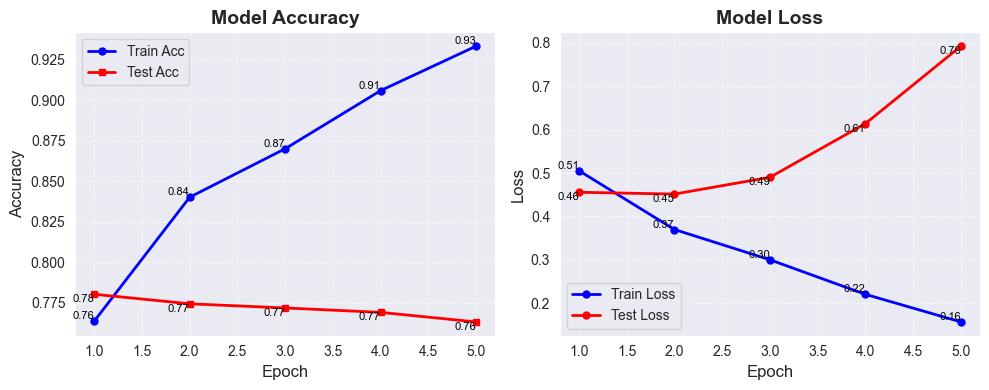

In [4]:
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1 )
sns.set_style("darkgrid") 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plotting the Accuracy Curve
axes[0].plot(epochs, accuracy, 'bo-', label='Train Acc', linewidth=2, markersize=5)  
axes[0].plot(epochs, val_acc, 'rs-', label='Test Acc', linewidth=2, markersize=5)  
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=10)
axes[0].grid(True, linestyle='--', alpha=0.6)

for i in range(len(accuracy)):
    axes[0].text(epochs[i], accuracy[i], f"{accuracy[i]:.2f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[0].text(epochs[i], val_acc[i], f"{val_acc[i]:.2f}", ha='right', va='top', fontsize=8, color='black')

# Plotting the Loss Curve
axes[1].plot(epochs, loss, 'bo-', label='Train Loss', linewidth=2, markersize=5)  
axes[1].plot(epochs, val_loss, 'ro-', label='Test Loss', linewidth=2, markersize=5)  
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower left', fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.6)

for i in range(len(loss)):
    axes[1].text(epochs[i], loss[i], f"{loss[i]:.2f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[1].text(epochs[i], val_loss[i], f"{val_loss[i]:.2f}", ha='right', va='top', fontsize=8, color='black')

plt.tight_layout()
plt.show()

### ROC-AUC


📌 ROC AUC: 0.8705


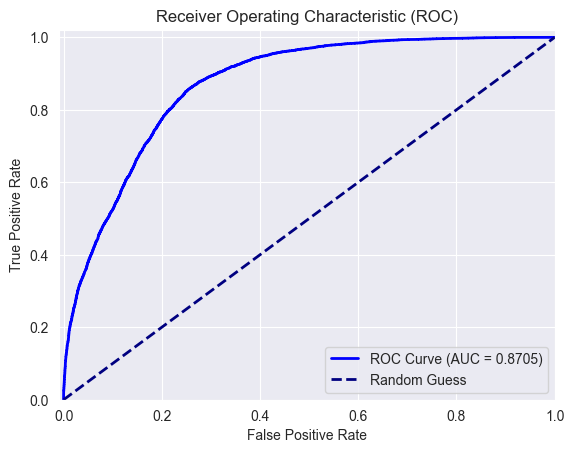

In [8]:
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

print(f"\n📌 ROC AUC: {roc_auc:.4f}")

plt.figure()

plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',label='Random Guess')

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


### PR Curve (precision_recall_curve)


📌 Precision-Recall AUC: 0.7363


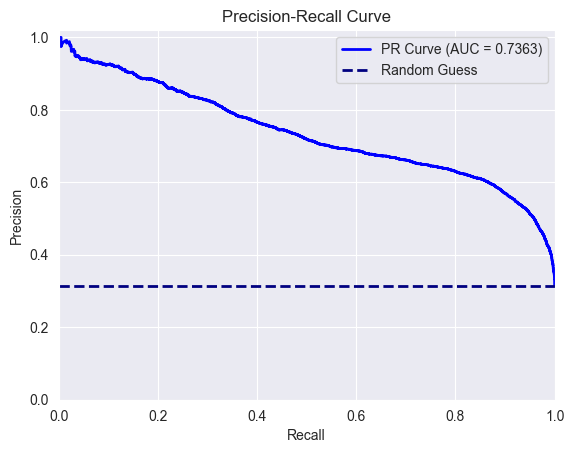

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(Y_test, y_pred_prob)
pr_auc = average_precision_score(Y_test, y_pred_prob)

print(f"\n📌 Precision-Recall AUC: {pr_auc:.4f}")

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')

baseline = sum(Y_test) / len(Y_test)  
plt.plot([0, 1], [baseline, baseline], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


###  Confusion Matrix

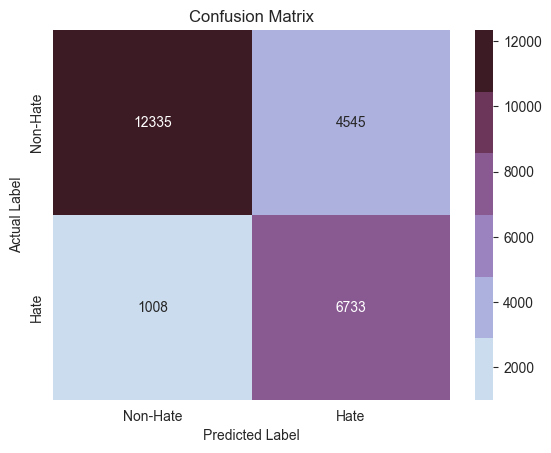

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap = sns.color_palette("ch:start=1,rot=-.5"),
            xticklabels=['Non-Hate', 'Hate'], 
            yticklabels=['Non-Hate', 'Hate'])


plt.xlabel("Predicted Label") 
plt.ylabel("Actual Label")  
plt.title("Confusion Matrix") 
plt.show()



# Model 2 + FastText

In [ ]:
# Load Data
file_path = r"..\Pre_Hate_Dataset\20_Hate_Final.csv"
data = pd.read_csv(file_path)
X = data['text'].astype(str).values  
Y = data['label'].values  
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

# Train test Split
X_train_orig, X_test_orig, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=42)

max_words = 20000  
max_len = 100  

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_orig)

# Hate Text (text for get hate speech feature)
X_train_seq = tokenizer.texts_to_sequences(X_train_orig)
X_test_seq = tokenizer.texts_to_sequences(X_test_orig)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Undersampling: 
    # Since the two data forms are different, use indices undersampling method and apply it to X_train_pad and X_train_orig
undersampler = RandomUnderSampler(random_state=42)
    # Generate dummy 2D indices [[0], [1], [2], ...] because fit_resample() requires 2D input
    # np.arange(len(Y_train)) creates [0, 1, 2, ..., n-1] (indices of all samples)
    # RandomUnderSampler require input 2D shape(n_samples, 1). 
    # reshape(-1, 1) converts 1D [1,2,3,4] to 2D shape [[1], [2], [3], [4], [5]]
dummy_indices = np.arange(len(Y_train)).reshape(-1, 1)
train_indices_resampled, Y_train_resampled = undersampler.fit_resample(dummy_indices, Y_train)
    # Apply the undersampled indices to X_train_pad (padded sequences) for hate speech feature extraction
    # .flatten() converts [[5], [89], [79], ...] to [5, 89, 79, ...] 
X_train_resampled = X_train_pad[train_indices_resampled.flatten()]
# Apply the same indices to X_train_orig (original text) for SenticNet feature extraction
# SenticNet requires raw text input, not numerical sequences
X_train_senticnet_resampled = [X_train_orig[i] for i in train_indices_resampled.flatten()]

# SenticNet Feature Extraction
def extract_sentic_features(text, tokenizer, max_length):
    sn = SenticNet()
    num_sentic_features = 24  # 24-dimensional features provided by SenticNet
    sentic_matrix = np.zeros((max_length, num_sentic_features), dtype=np.float32)

    tokens = word_tokenize(text) 
    token_indices = tokenizer.texts_to_sequences([tokens])[0] # Convert to index (exp: [4, 10, 7])
    
    for i, token_idx in enumerate(token_indices[:max_length]):
        word = tokenizer.index_word.get(token_idx, '') # Reverse search for a word based on the index (exp: 4 → "I")
        try:
            # sn.concept(word): Query the sentiment features of word word in SenticNet
            sentic_values = [float(sn.concept(word)[j]) for j in range(num_sentic_features)]
            sentic_matrix[i] = sentic_values
        except KeyError:
            pass  # If SenticNet does not have the feature of this word, write 0
    return sentic_matrix

def batch_extract_sentic(texts, tokenizer, max_length):
    sentic_features = np.array([extract_sentic_features(text, tokenizer, max_length) for text in texts])
    return sentic_features.astype(np.float32)

x_train_sentic = batch_extract_sentic(X_train_senticnet_resampled, tokenizer, max_len)
x_test_sentic = batch_extract_sentic(X_test_orig, tokenizer, max_len)

# ------------------------------------------------------------------------------------------------------------------------
print("\n=== Word Embedding Representation ===")
print("X_train_resampled shape:", X_train_resampled.shape)
print("Y_train_resampled shape:", Y_train_resampled.shape)
print("X_test_pad shape:", X_test_pad.shape)
print("Y_test shape:", Y_test.shape)

print("\n=== SenticNet Representation ===")
print("x_train_sentic shape:", x_train_sentic.shape)
print("Y_train_resampled shape:", Y_train_resampled.shape)
print("x_test_sentic shape:", x_test_sentic.shape)
print("Y_test shape:", Y_test.shape)
# ------------------------------------------------------------------------------------------------------------------------

# 8. Build Model
MAX_VOCAB_SIZE = len(tokenizer.word_index) + 1  
MAX_SEQUENCE_LENGTH = 100 
EMBEDDING_DIM = 300
NUM_SENTIC_FEATURES = 24

def build_hybrid_model(tokenizer, word_vectors, max_sequence_length=100):
    embedding_matrix = np.zeros((MAX_VOCAB_SIZE, EMBEDDING_DIM))
    for word, i in tokenizer.word_index.items():
        if i < MAX_VOCAB_SIZE:
            if word in word_vectors.wv:
                embedding_matrix[i] = word_vectors.wv[word]
            else:
                embedding_matrix[i] = np.random.normal(size=(EMBEDDING_DIM,))

    text_input = Input(shape=(max_sequence_length,), name='text_input')
    sentic_input = Input(shape=(max_sequence_length, NUM_SENTIC_FEATURES), name='sentic_input')
    
    embedding_layer = Embedding(
        input_dim=MAX_VOCAB_SIZE,
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=max_sequence_length,
        trainable=False,
        mask_zero=False
    )(text_input)
    merged_features = Concatenate()([embedding_layer, sentic_input])

    x = Bidirectional(LSTM(64, return_sequences=True))(merged_features)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(96, return_sequences=True))(x)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(48, return_sequences=False))(x)
    x = Dropout(0.2)(x)
    x = Dense(48, activation='relu', kernel_regularizer=l2(0.001))(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[text_input, sentic_input], outputs=output)
    return model

fasttext_path = "crawl-300d-2M-subword.bin" 
word_vectors = FastText.load_fasttext_format(fasttext_path)
model = build_hybrid_model(tokenizer, word_vectors, MAX_SEQUENCE_LENGTH)

model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=0.003),
    metrics=["accuracy"]
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   
    factor=0.5,           # Decrease LR (current LR * 0.5)
    patience=1,           # If val_loss does not improve for 1 epoch, reduce LR
    min_lr=0.0001,        # Setting minimum learning rate to prevent it from being too low
    verbose=1             
)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    [X_train_resampled, x_train_sentic],Y_train_resampled,
    epochs=15, batch_size=32,
    validation_data=([X_test_pad, x_test_sentic], Y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

model.save("BiLSTM_FastText_SenticNet_Hybrid_model.keras")
joblib.dump(history.history, "BiLSTM_FastText_SenticNet_Hybrid_History.pkl")
print("Hybrid model saved successfully!")


=== Word Embedding Representation ===
X_train_resampled shape: (36126, 100)
Y_train_resampled shape: (36126,)
X_test_pad shape: (24621, 100)
Y_test shape: (24621,)

=== SenticNet Representation ===
x_train_sentic shape: (36126, 100, 24)
Y_train_resampled shape: (36126,)
x_test_sentic shape: (24621, 100, 24)
Y_test shape: (24621,)


C:\Users\Asus\AppData\Local\Temp\ipykernel_30924\929616338.py:185: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  word_vectors = FastText.load_fasttext_format(fasttext_path)



Testing input


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Testing merged_features

Testing LSTM
Epoch 1/15
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 137s 115ms/step - accuracy: 0.7079 - loss: 0.5885 - val_accuracy: 0.7613 - val_loss: 0.4799 - learning_rate: 0.0030
Epoch 2/15
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 128s 114ms/step - accuracy: 0.7466 - loss: 0.5263 - val_accuracy: 0.7631 - val_loss: 0.4733 - learning_rate: 0.0030
Epoch 3/15
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7834 - loss: 0.4782
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 139s 123ms/step - accuracy: 0.7834 - loss: 0.4782 - val_accuracy: 0.7489 - val_loss: 0.4881 - learning_rate: 0.0030
Epoch 4/15
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 143s 126ms/step - accuracy: 0.7973 - loss: 0.4514 - val_accuracy: 0.7882 - val_loss: 0.4439 - learning_rate: 0.0015
Epoch 5/15
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7512 - loss: 0.5008
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.000750000006519258.
1129/1129 ━

### Evaluate


In [ ]:
train_loss, train_accuracy = model.evaluate(
    [X_train_resampled, x_train_sentic], 
    Y_train_resampled,
    verbose=1
)

test_loss, test_accuracy = model.evaluate(
    [X_test_pad, x_test_sentic],
    Y_test,
    verbose=1
)

y_pred_prob = model.predict([X_test_pad, x_test_sentic])
y_pred = (y_pred_prob > 0.5).astype(int)

print(f"\n📌 Train Accuracy: {train_accuracy:.4f}")
print(f"📌 Test Accuracy: {test_accuracy:.4f}")

f1_weighted = f1_score(Y_test, y_pred, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

f1_micro = f1_score(Y_test, y_pred, average='micro')
print(f"📌 Micro F1 Score: {f1_micro:.4f}")

f1_macro = f1_score(Y_test, y_pred, average='macro')
print(f"📌 Macro F1 Score: {f1_macro:.4f}")

precision = precision_score(Y_test, y_pred, average='binary') 
print(f"\n📌 Precision: {precision:.4f}")

recall = recall_score(Y_test, y_pred, average='binary')
print(f"📌 Recall: {recall:.4f}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"\n📌Test ROC AUC: {roc_auc:.4f}")

print("\n📌 Classification Report:")
print(classification_report(Y_test, y_pred))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(Y_test, y_pred))


1129/1129 ━━━━━━━━━━━━━━━━━━━━ 37s 33ms/step - accuracy: 0.7943 - loss: 0.4080
770/770 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.7879 - loss: 0.4403
770/770 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step

📌 Train Accuracy: 0.8180
📌 Test Accuracy: 0.7903

📌 Weighted F1 Score: 0.7967
📌 Micro F1 Score: 0.7903
📌 Macro F1 Score: 0.7746

📌 Precision: 0.6239
📌 Recall: 0.8380

📌Test ROC AUC: 0.8758

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.77      0.83     16880
           1       0.62      0.84      0.72      7741

    accuracy                           0.79     24621
   macro avg       0.77      0.80      0.77     24621
weighted avg       0.82      0.79      0.80     24621


📌 Confusion Matrix:
[[12970  3910]
 [ 1254  6487]]


### Learning Curve

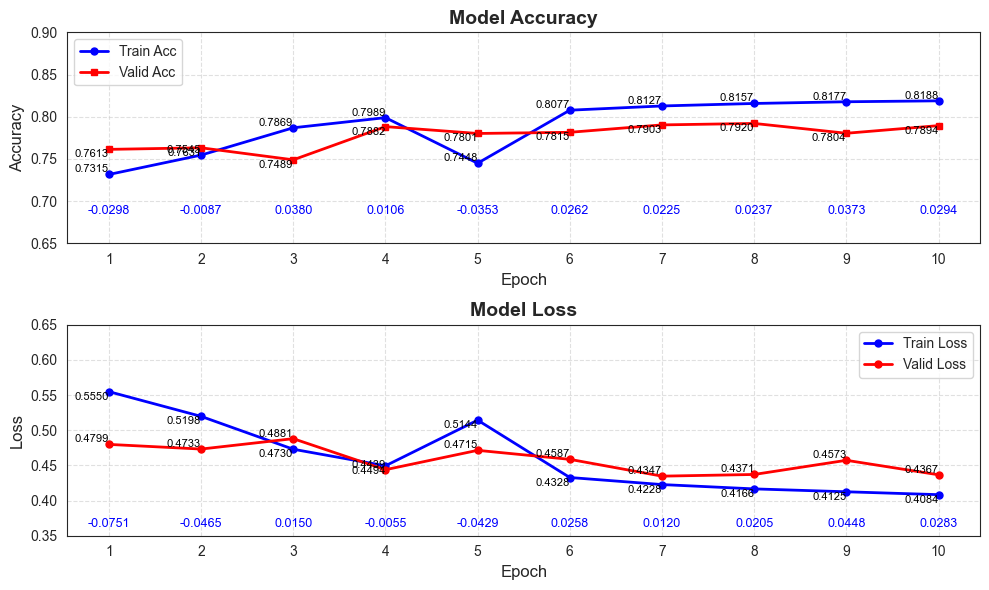

In [ ]:
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6)) 
# Plotting the Accuracy Curve
axes[0].plot(epochs, accuracy, 'bo-', label='Train Acc', linewidth=2, markersize=5)  
axes[0].plot(epochs, val_acc, 'rs-', label='Valid Acc', linewidth=2, markersize=5)  
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=10)

# backgroud column grid
axes[0].grid(True, linestyle='--', alpha=0.6)

for i in range(len(accuracy)):
    axes[0].text(epochs[i], accuracy[i], f"{accuracy[i]:.4f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[0].text(epochs[i], val_acc[i], f"{val_acc[i]:.4f}", ha='right', va='top', fontsize=8, color='black')

# Plotting the Loss Curve
axes[1].plot(epochs, loss, 'bo-', label='Train Loss', linewidth=2, markersize=5)  
axes[1].plot(epochs, val_loss, 'ro-', label='Valid Loss', linewidth=2, markersize=5)  
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.6)

for i in range(len(loss)):
    axes[1].text(epochs[i], loss[i], f"{loss[i]:.4f}", ha='right', va='top', fontsize=8, color='black')
    axes[1].text(epochs[i], val_loss[i], f"{val_loss[i]:.4f}", ha='right', va='bottom', fontsize=8, color='black')

axes[0].set_xticks(range(1, len(epochs) + 1, 1)) 
axes[1].set_xticks(range(1, len(epochs) + 1, 1))  

acc_diff = [round(accuracy[i] - val_acc[i], 4) for i in range(len(accuracy))]
loss_diff = [round(val_loss[i] - loss[i] , 4) for i in range(len(loss))]

# Display the difference between Train and Test
for i in range(len(epochs)):
    axes[0].text(epochs[i], min(accuracy) -0.05, f"{acc_diff[i]:.4f}", 
                 ha='center', va='bottom', fontsize=9, color='blue')
    
    axes[1].text(epochs[i], min(loss) -0.05, f"{loss_diff[i]:.4f}", 
                 ha='center', va='bottom', fontsize=9, color='blue')
    
axes[0].set_ylim(0.65, 0.90)
axes[1].set_ylim(0.35, 0.65)

plt.tight_layout()
plt.show()



### ROC-AUC


📌 ROC AUC: 0.8758


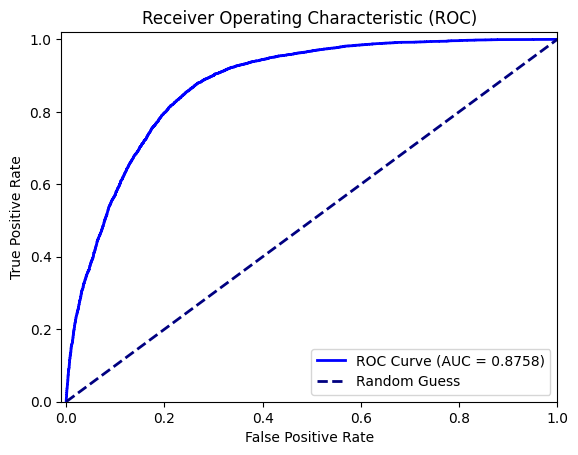

In [ ]:
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

print(f"\n📌 ROC AUC: {roc_auc:.4f}")

plt.figure()

plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',label='Random Guess')

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


### PR Curve (precision_recall_curve)


📌 Precision-Recall AUC: 0.7366


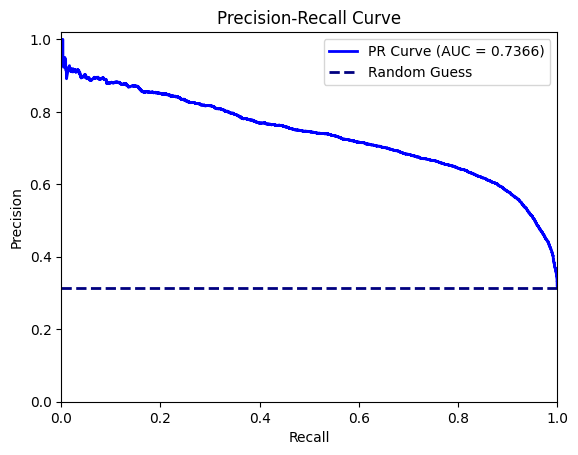

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(Y_test, y_pred_prob)
pr_auc = average_precision_score(Y_test, y_pred_prob)

print(f"\n📌 Precision-Recall AUC: {pr_auc:.4f}")

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')

baseline = sum(Y_test) / len(Y_test)  
plt.plot([0, 1], [baseline, baseline], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


###  Confusion Matrix

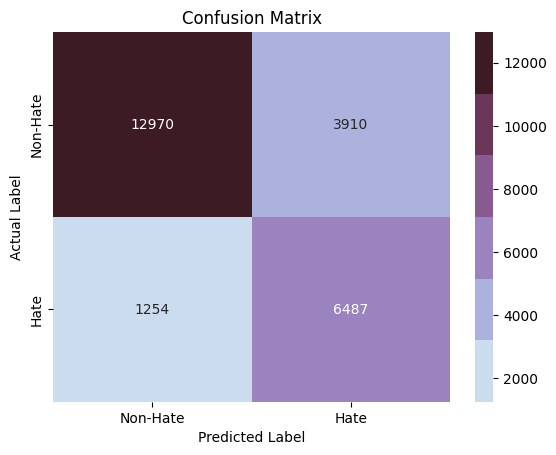

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap = sns.color_palette("ch:start=1,rot=-.5"),
            xticklabels=['Non-Hate', 'Hate'], 
            yticklabels=['Non-Hate', 'Hate'])

plt.xlabel("Predicted Label") 
plt.ylabel("Actual Label")  
plt.title("Confusion Matrix") 
plt.show()



# Model 3 + FastText + Focal Loss

In [ ]:
# Load Data
file_path = r"..\Pre_Hate_Dataset\20_Hate_Final.csv"
data = pd.read_csv(file_path)
X = data['text'].astype(str).values  
Y = data['label'].values  
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

# Train test Split
X_train_orig, X_test_orig, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=42)

max_words = 20000  
max_len = 100  

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_orig)

# Hate Text (text for get hate speech feature)
X_train_seq = tokenizer.texts_to_sequences(X_train_orig)
X_test_seq = tokenizer.texts_to_sequences(X_test_orig)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Undersampling: 
    # Since the two data forms are different, use indices undersampling method and apply it to X_train_pad and X_train_orig
undersampler = RandomUnderSampler(random_state=42)
    # Generate dummy 2D indices [[0], [1], [2], ...] because fit_resample() requires 2D input
    # np.arange(len(Y_train)) creates [0, 1, 2, ..., n-1] (indices of all samples)
    # RandomUnderSampler require input 2D shape(n_samples, 1). 
    # reshape(-1, 1) converts 1D [1,2,3,4] to 2D shape [[1], [2], [3], [4], [5]]
dummy_indices = np.arange(len(Y_train)).reshape(-1, 1)
train_indices_resampled, Y_train_resampled = undersampler.fit_resample(dummy_indices, Y_train)
    # Apply the undersampled indices to X_train_pad (padded sequences) for hate speech feature extraction
    # .flatten() converts [[5], [89], [79], ...] to [5, 89, 79, ...] 
X_train_resampled = X_train_pad[train_indices_resampled.flatten()]
# Apply the same indices to X_train_orig (original text) for SenticNet feature extraction
# SenticNet requires raw text input, not numerical sequences
X_train_senticnet_resampled = [X_train_orig[i] for i in train_indices_resampled.flatten()]

# SenticNet Feature Extraction
def extract_sentic_features(text, tokenizer, max_length):
    sn = SenticNet()
    num_sentic_features = 24  # 24-dimensional features provided by SenticNet
    sentic_matrix = np.zeros((max_length, num_sentic_features), dtype=np.float32)

    tokens = word_tokenize(text) 
    token_indices = tokenizer.texts_to_sequences([tokens])[0] # Convert to index (exp: [4, 10, 7])
    
    for i, token_idx in enumerate(token_indices[:max_length]):
        word = tokenizer.index_word.get(token_idx, '') # Reverse search for a word based on the index (exp: 4 → "I")
        try:
            # sn.concept(word): Query the sentiment features of word word in SenticNet
            sentic_values = [float(sn.concept(word)[j]) for j in range(num_sentic_features)]
            sentic_matrix[i] = sentic_values
        except KeyError:
            pass  # If SenticNet does not have the feature of this word, write 0
    return sentic_matrix

def batch_extract_sentic(texts, tokenizer, max_length):
    sentic_features = np.array([extract_sentic_features(text, tokenizer, max_length) for text in texts])
    return sentic_features.astype(np.float32)

x_train_sentic = batch_extract_sentic(X_train_senticnet_resampled, tokenizer, max_len)
x_test_sentic = batch_extract_sentic(X_test_orig, tokenizer, max_len)

# ------------------------------------------------------------------------------------------------------------------------
print("\n=== Word Embedding Representation ===")
print("X_train_resampled shape:", X_train_resampled.shape)
print("Y_train_resampled shape:", Y_train_resampled.shape)
print("X_test_pad shape:", X_test_pad.shape)
print("Y_test shape:", Y_test.shape)

print("\n=== SenticNet Representation ===")
print("x_train_sentic shape:", x_train_sentic.shape)
print("Y_train_resampled shape:", Y_train_resampled.shape)
print("x_test_sentic shape:", x_test_sentic.shape)
print("Y_test shape:", Y_test.shape)
# ------------------------------------------------------------------------------------------------------------------------

# 8. Build Model
MAX_VOCAB_SIZE = len(tokenizer.word_index) + 1  
MAX_SEQUENCE_LENGTH = 100 
EMBEDDING_DIM = 300
NUM_SENTIC_FEATURES = 24

def build_hybrid_model(tokenizer, word_vectors, max_sequence_length):
    embedding_matrix = np.zeros((MAX_VOCAB_SIZE, EMBEDDING_DIM))
    for word, i in tokenizer.word_index.items():
        if i < MAX_VOCAB_SIZE:
            if word in word_vectors.wv:
                embedding_matrix[i] = word_vectors.wv[word]
            else:
                embedding_matrix[i] = np.random.normal(size=(EMBEDDING_DIM,))

    text_input = Input(shape=(max_sequence_length,), name='text_input')
    sentic_input = Input(shape=(max_sequence_length, NUM_SENTIC_FEATURES), name='sentic_input')

    embedding_layer = Embedding(
        input_dim=MAX_VOCAB_SIZE,
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=max_sequence_length,
        trainable=False,
        mask_zero=False
    )(text_input)
    
    merged_features = Concatenate()([embedding_layer, sentic_input])

    x = Bidirectional(LSTM(64, return_sequences=True))(merged_features)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(96, return_sequences=True))(x)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(48, return_sequences=False))(x)
    x = Dropout(0.2)(x)
    x = Dense(48, activation='relu', kernel_regularizer=l2(0.001))(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[text_input, sentic_input], outputs=output)
    return model

fasttext_path = "crawl-300d-2M-subword.bin" 
word_vectors = FastText.load_fasttext_format(fasttext_path)
model = build_hybrid_model(tokenizer, word_vectors, MAX_SEQUENCE_LENGTH)

# ------------------------------------------------------------------------------------------------------------------------------
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend as K

@register_keras_serializable(package="CustomLoss")
# Function focal_loss code et from GitHub (aldi-dimara, 2018)
def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.55): 
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
    pt = tf.where(K.equal(y_true, 1), y_pred, 1-y_pred)
    alpha_factor = K.ones_like(y_true)*alpha
    alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1-alpha_factor)
    cross_entropy = -K.log(pt)
    weight = alpha_t * K.pow((1-pt), gamma)
    loss = weight * cross_entropy
    loss = K.mean(loss, axis=1)
    return loss

model.compile(
    loss=focal_loss,
    optimizer=Adam(learning_rate=0.003),
    metrics=["accuracy"]
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   
    factor=0.5,           # Decrease LR (current LR * 0.5)
    patience=1,           # If val_loss does not improve for 1 epoch, reduce LR
    min_lr=0.0001,        # Setting minimum learning rate to prevent it from being too low
    verbose=1             
)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    [X_train_resampled, x_train_sentic], Y_train_resampled,
    epochs=15, batch_size=32,
    validation_data=([X_test_pad, x_test_sentic], Y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

model.save("BiLSTM_FastText_SenticNet_Hybrid_model.keras")
joblib.dump(history.history, "BiLSTM_FastText_SenticNet_Hybrid_History.pkl")
print("Hybrid model saved successfully!")


=== Word Embedding Representation ===
X_train_resampled shape: (36126, 100)
Y_train_resampled shape: (36126,)
X_test_pad shape: (24621, 100)
Y_test shape: (24621,)

=== SenticNet Representation ===
x_train_sentic shape: (36126, 100, 24)
Y_train_resampled shape: (36126,)
x_test_sentic shape: (24621, 100, 24)
Y_test shape: (24621,)


C:\Users\Asus\AppData\Local\Temp\ipykernel_19316\1176058204.py:185: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  word_vectors = FastText.load_fasttext_format(fasttext_path)



Testing input


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Testing merged_features

Testing LSTM
Epoch 1/15
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 155s 129ms/step - accuracy: 0.7103 - loss: 0.0776 - val_accuracy: 0.3144 - val_loss: 0.0987 - learning_rate: 0.0030
Epoch 2/15
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 137s 122ms/step - accuracy: 0.5020 - loss: 0.0866 - val_accuracy: 0.3144 - val_loss: 0.0858 - learning_rate: 0.0030
Epoch 3/15
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 136s 121ms/step - accuracy: 0.5711 - loss: 0.0801 - val_accuracy: 0.7547 - val_loss: 0.0579 - learning_rate: 0.0030
Epoch 4/15
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7976 - loss: 0.0578
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 134s 119ms/step - accuracy: 0.7976 - loss: 0.0578 - val_accuracy: 0.7632 - val_loss: 0.0608 - learning_rate: 0.0030
Epoch 5/15
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 139s 123ms/step - accuracy: 0.8110 - loss: 0.0536 - val_accuracy: 0.7649 - val_loss: 0.0567 - learning_rate: 0.0015
Epoch 6/15
1129/11

### Evaluate


In [ ]:
train_loss, train_accuracy = model.evaluate(
    [X_train_resampled, x_train_sentic], 
    Y_train_resampled,
    verbose=1
)

test_loss, test_accuracy = model.evaluate(
    [X_test_pad, x_test_sentic],
    Y_test,
    verbose=1
)

y_pred_prob = model.predict([X_test_pad, x_test_sentic])
y_pred = (y_pred_prob > 0.5).astype(int)

print(f"\n📌 Train Accuracy: {train_accuracy:.4f}")
print(f"📌 Test Accuracy: {test_accuracy:.4f}")

f1_weighted = f1_score(Y_test, y_pred, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

f1_micro = f1_score(Y_test, y_pred, average='micro')
print(f"📌 Micro F1 Score: {f1_micro:.4f}")

f1_macro = f1_score(Y_test, y_pred, average='macro')
print(f"📌 Macro F1 Score: {f1_macro:.4f}")

precision = precision_score(Y_test, y_pred, average='binary') 
print(f"\n📌 Precision: {precision:.4f}")

recall = recall_score(Y_test, y_pred, average='binary')
print(f"📌 Recall: {recall:.4f}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"\n📌Test ROC AUC: {roc_auc:.4f}")

print("\n📌 Classification Report:")
print(classification_report(Y_test, y_pred))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(Y_test, y_pred))


1129/1129 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.7888 - loss: 0.0473
770/770 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.7870 - loss: 0.0554
770/770 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step

📌 Train Accuracy: 0.8375
📌 Test Accuracy: 0.7871

📌 Weighted F1 Score: 0.7944
📌 Micro F1 Score: 0.7871
📌 Macro F1 Score: 0.7751

📌 Precision: 0.6116
📌 Recall: 0.8846

📌Test ROC AUC: 0.8878

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.74      0.83     16880
           1       0.61      0.88      0.72      7741

    accuracy                           0.79     24621
   macro avg       0.77      0.81      0.78     24621
weighted avg       0.83      0.79      0.79     24621


📌 Confusion Matrix:
[[12531  4349]
 [  893  6848]]


### Learning Curve

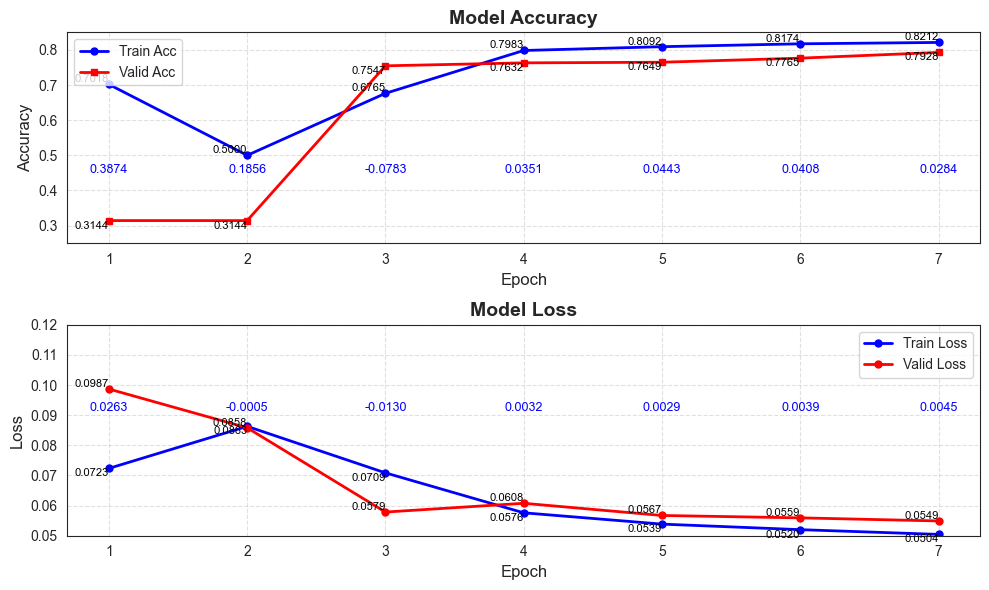

In [ ]:
accuracy = history.history['accuracy'][:7]
val_acc = history.history['val_accuracy'][:7]
loss = history.history['loss'][:7]
val_loss = history.history['val_loss'][:7]

epochs = range(1, len(accuracy) + 1)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

# Plotting the Accuracy Curve
axes[0].plot(epochs, accuracy, 'bo-', label='Train Acc', linewidth=2, markersize=5)  
axes[0].plot(epochs, val_acc, 'rs-', label='Valid Acc', linewidth=2, markersize=5)  
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=10)

# backgroud column grid
axes[0].grid(True, linestyle='--', alpha=0.6)

for i in range(len(accuracy)):
    axes[0].text(epochs[i], accuracy[i], f"{accuracy[i]:.4f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[0].text(epochs[i], val_acc[i], f"{val_acc[i]:.4f}", ha='right', va='top', fontsize=8, color='black')

# Plotting the Loss Curve
axes[1].plot(epochs, loss, 'bo-', label='Train Loss', linewidth=2, markersize=5)  
axes[1].plot(epochs, val_loss, 'ro-', label='Valid Loss', linewidth=2, markersize=5)  
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.6)

for i in range(len(loss)):
    axes[1].text(epochs[i], loss[i], f"{loss[i]:.4f}", ha='right', va='top', fontsize=8, color='black')
    axes[1].text(epochs[i], val_loss[i], f"{val_loss[i]:.4f}", ha='right', va='bottom', fontsize=8, color='black')

axes[0].set_xticks(range(1, len(epochs) + 1, 1)) 
axes[1].set_xticks(range(1, len(epochs) + 1, 1))  

acc_diff = [round(accuracy[i] - val_acc[i], 4) for i in range(len(accuracy))]
loss_diff = [round(val_loss[i] - loss[i] , 4) for i in range(len(loss))]

# Display the difference between Train and Test
for i in range(len(epochs)):
    axes[0].text(epochs[i], min(accuracy) -0.06, f"{acc_diff[i]:.4f}", 
                 ha='center', va='bottom', fontsize=9, color='blue')
    
    axes[1].text(epochs[i], min(loss) +0.04, f"{loss_diff[i]:.4f}", 
                 ha='center', va='bottom', fontsize=9, color='blue')
    
axes[0].set_ylim(0.25, 0.85)
axes[1].set_ylim(0.05, 0.12)

plt.tight_layout()
plt.show()


### ROC-AUC


📌 ROC AUC: 0.8878


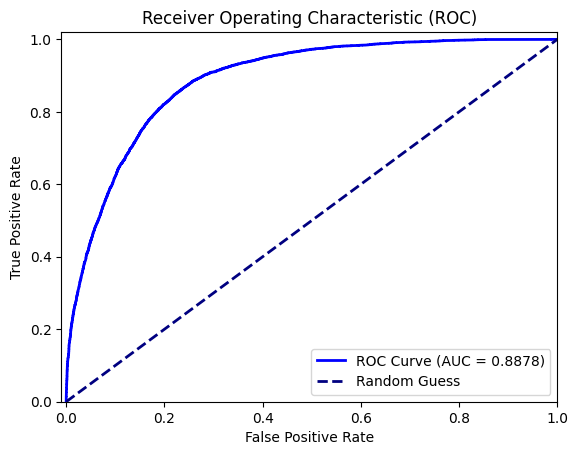

In [ ]:
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

print(f"\n📌 ROC AUC: {roc_auc:.4f}")

plt.figure()

plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',label='Random Guess')

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


### PR Curve (precision_recall_curve)


📌 Precision-Recall AUC: 0.7725


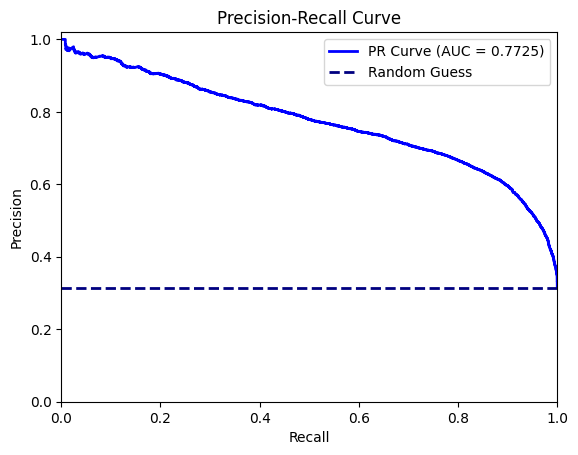

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(Y_test, y_pred_prob)
pr_auc = average_precision_score(Y_test, y_pred_prob)

print(f"\n📌 Precision-Recall AUC: {pr_auc:.4f}")

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')

baseline = sum(Y_test) / len(Y_test)  
plt.plot([0, 1], [baseline, baseline], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


###  Confusion Matrix

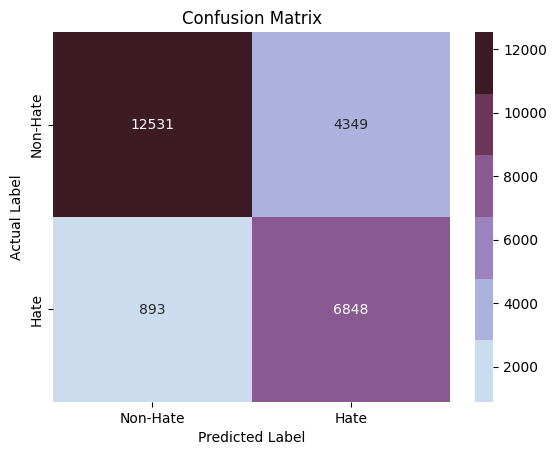

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap = sns.color_palette("ch:start=1,rot=-.5"),
            xticklabels=['Non-Hate', 'Hate'], 
            yticklabels=['Non-Hate', 'Hate'])


plt.xlabel("Predicted Label") 
plt.ylabel("Actual Label")  
plt.title("Confusion Matrix") 
plt.show()



# Model 4 = Model 3 (change dataset) Including Stop Word

In [2]:
# Load Data
file_path = r"..\Pre_Hate_Dataset\Final_StopWord.csv"
data = pd.read_csv(file_path)
X = data['text'].astype(str).values  
Y = data['label'].values  
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

# Train test Split
X_train_orig, X_test_orig, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=42)

max_words = 20000  
max_len = 100  

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_orig)

# Hate Text (text for get hate speech feature)
X_train_seq = tokenizer.texts_to_sequences(X_train_orig)
X_test_seq = tokenizer.texts_to_sequences(X_test_orig)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Undersampling: 
    # Since the two data forms are different, use indices undersampling method and apply it to X_train_pad and X_train_orig
undersampler = RandomUnderSampler(random_state=42)
    # Generate dummy 2D indices [[0], [1], [2], ...] because fit_resample() requires 2D input
    # np.arange(len(Y_train)) creates [0, 1, 2, ..., n-1] (indices of all samples)
    # RandomUnderSampler require input 2D shape(n_samples, 1). 
    # reshape(-1, 1) converts 1D [1,2,3,4] to 2D shape [[1], [2], [3], [4], [5]]
dummy_indices = np.arange(len(Y_train)).reshape(-1, 1)
train_indices_resampled, Y_train_resampled = undersampler.fit_resample(dummy_indices, Y_train)
    # Apply the undersampled indices to X_train_pad (padded sequences) for hate speech feature extraction
    # .flatten() converts [[5], [89], [79], ...] to [5, 89, 79, ...] 
X_train_resampled = X_train_pad[train_indices_resampled.flatten()]
# Apply the same indices to X_train_orig (original text) for SenticNet feature extraction
# SenticNet requires raw text input, not numerical sequences
X_train_senticnet_resampled = [X_train_orig[i] for i in train_indices_resampled.flatten()]

# SenticNet Feature Extraction
def extract_sentic_features(text, tokenizer, max_length):
    sn = SenticNet()
    num_sentic_features = 24  # 24-dimensional features provided by SenticNet
    sentic_matrix = np.zeros((max_length, num_sentic_features), dtype=np.float32)

    tokens = word_tokenize(text) 
    token_indices = tokenizer.texts_to_sequences([tokens])[0] # Convert to index (exp: [4, 10, 7])
    
    for i, token_idx in enumerate(token_indices[:max_length]):
        word = tokenizer.index_word.get(token_idx, '') # Reverse search for a word based on the index (exp: 4 → "I")
        try:
            # sn.concept(word): Query the sentiment features of word word in SenticNet
            sentic_values = [float(sn.concept(word)[j]) for j in range(num_sentic_features)]
            sentic_matrix[i] = sentic_values
        except KeyError:
            pass  # If SenticNet does not have the feature of this word, write 0
    return sentic_matrix

def batch_extract_sentic(texts, tokenizer, max_length):
    sentic_features = np.array([extract_sentic_features(text, tokenizer, max_length) for text in texts])
    return sentic_features.astype(np.float32)

x_train_sentic = batch_extract_sentic(X_train_senticnet_resampled, tokenizer, max_len)
x_test_sentic = batch_extract_sentic(X_test_orig, tokenizer, max_len)

# ------------------------------------------------------------------------------------------------------------------------
print("\n=== Word Embedding Representation ===")
print("X_train_resampled shape:", X_train_resampled.shape)
print("Y_train_resampled shape:", Y_train_resampled.shape)
print("X_test_pad shape:", X_test_pad.shape)
print("Y_test shape:", Y_test.shape)

print("\n=== SenticNet Representation ===")
print("x_train_sentic shape:", x_train_sentic.shape)
print("Y_train_resampled shape:", Y_train_resampled.shape)
print("x_test_sentic shape:", x_test_sentic.shape)
print("Y_test shape:", Y_test.shape)
# ------------------------------------------------------------------------------------------------------------------------

# 8. Build Model
MAX_VOCAB_SIZE = len(tokenizer.word_index) + 1  
MAX_SEQUENCE_LENGTH = 100 
EMBEDDING_DIM = 300
NUM_SENTIC_FEATURES = 24

def build_hybrid_model(tokenizer, word_vectors, max_sequence_length):
    embedding_matrix = np.zeros((MAX_VOCAB_SIZE, EMBEDDING_DIM))
    for word, i in tokenizer.word_index.items():
        if i < MAX_VOCAB_SIZE:
            if word in word_vectors.wv:
                embedding_matrix[i] = word_vectors.wv[word]
            else:
                embedding_matrix[i] = np.random.normal(size=(EMBEDDING_DIM,))

    text_input = Input(shape=(max_sequence_length,), name='text_input')
    sentic_input = Input(shape=(max_sequence_length, NUM_SENTIC_FEATURES), name='sentic_input')

    embedding_layer = Embedding(
        input_dim=MAX_VOCAB_SIZE,
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=max_sequence_length,
        trainable=False,
        mask_zero=False
    )(text_input)
    
    merged_features = Concatenate()([embedding_layer, sentic_input])

    x = Bidirectional(LSTM(64, return_sequences=True))(merged_features)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(96, return_sequences=True))(x)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(48, return_sequences=False))(x)
    x = Dropout(0.2)(x)
    x = Dense(48, activation='relu', kernel_regularizer=l2(0.001))(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[text_input, sentic_input], outputs=output)
    return model

fasttext_path = "crawl-300d-2M-subword.bin" 
word_vectors = FastText.load_fasttext_format(fasttext_path)
model = build_hybrid_model(tokenizer, word_vectors, MAX_SEQUENCE_LENGTH)

# ------------------------------------------------------------------------------------------------------------------------------
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend as K

@register_keras_serializable(package="CustomLoss")
# Function focal_loss code et from GitHub (aldi-dimara, 2018)
def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.55): 
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
    pt = tf.where(K.equal(y_true, 1), y_pred, 1-y_pred)
    alpha_factor = K.ones_like(y_true)*alpha
    alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1-alpha_factor)
    cross_entropy = -K.log(pt)
    weight = alpha_t * K.pow((1-pt), gamma)
    loss = weight * cross_entropy
    loss = K.mean(loss, axis=1)
    return loss

model.compile(
    loss=focal_loss,
    optimizer=Adam(learning_rate=0.003),
    metrics=["accuracy"]
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   
    factor=0.5,           # Decrease LR (current LR * 0.5)
    patience=1,           # If val_loss does not improve for 1 epoch, reduce LR
    min_lr=0.0001,        # Setting minimum learning rate to prevent it from being too low
    verbose=1             
)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    [X_train_resampled, x_train_sentic], Y_train_resampled,
    epochs=15, batch_size=32,
    validation_data=([X_test_pad, x_test_sentic], Y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

model.save("BiLSTM_FastText_SenticNet_StopWord_Model.keras")
joblib.dump(history.history, "BiLSTM_FastText_SenticNet_StopWord_History.pkl")
print("Hybrid model saved successfully!")


=== Word Embedding Representation ===
X_train_resampled shape: (35868, 100)
Y_train_resampled shape: (35868,)
X_test_pad shape: (24511, 100)
Y_test shape: (24511,)

=== SenticNet Representation ===
x_train_sentic shape: (35868, 100, 24)
Y_train_resampled shape: (35868,)
x_test_sentic shape: (24511, 100, 24)
Y_test shape: (24511,)


C:\Users\Asus\AppData\Local\Temp\ipykernel_23032\2561833308.py:122: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  word_vectors = FastText.load_fasttext_format(fasttext_path)
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 134s 113ms/step - accuracy: 0.7043 - loss: 0.0778 - val_accuracy: 0.7544 - val_loss: 0.0641 - learning_rate: 0.0030
Epoch 2/15
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 130s 116ms/step - accuracy: 0.7912 - loss: 0.0584 - val_accuracy: 0.7818 - val_loss: 0.0588 - learning_rate: 0.0030
Epoch 3/15
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 119s 106ms/step - accuracy: 0.7921 - loss: 0.0581 - val_accuracy: 0.7728 - val_loss: 0.0553 - learning_rate: 0.0030
Epoch 4/15
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 124s 111ms/step - accuracy: 0.8143 - loss: 0.0530 - val_accuracy: 0.8057 - val_loss: 0.0538 - learning_rate: 0.0030
Epoch 5/15
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8231 - loss: 0.0506
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 125s 112ms/step - accuracy: 0.8231 - loss: 0.0506 - val_accuracy: 0.7615 - val_loss: 0.0644 - learning_rate: 0.0030
Epoch 6/15
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - 

### Evaluate


In [3]:
train_loss, train_accuracy = model.evaluate(
    [X_train_resampled, x_train_sentic], 
    Y_train_resampled,
    verbose=1
)

test_loss, test_accuracy = model.evaluate(
    [X_test_pad, x_test_sentic],
    Y_test,
    verbose=1
)

y_pred_prob = model.predict([X_test_pad, x_test_sentic])
y_pred = (y_pred_prob > 0.5).astype(int)

print(f"\n📌 Train Accuracy: {train_accuracy:.4f}")
print(f"📌 Test Accuracy: {test_accuracy:.4f}")

f1_weighted = f1_score(Y_test, y_pred, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

f1_micro = f1_score(Y_test, y_pred, average='micro')
print(f"📌 Micro F1 Score: {f1_micro:.4f}")

f1_macro = f1_score(Y_test, y_pred, average='macro')
print(f"📌 Macro F1 Score: {f1_macro:.4f}")

precision = precision_score(Y_test, y_pred, average='binary') 
print(f"\n📌 Precision: {precision:.4f}")

recall = recall_score(Y_test, y_pred, average='binary')
print(f"📌 Recall: {recall:.4f}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"\n📌Test ROC AUC: {roc_auc:.4f}")

print("\n📌 Classification Report:")
print(classification_report(Y_test, y_pred))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(Y_test, y_pred))


1121/1121 ━━━━━━━━━━━━━━━━━━━━ 37s 33ms/step - accuracy: 0.8185 - loss: 0.0490
766/766 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.8041 - loss: 0.0536
766/766 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step

📌 Train Accuracy: 0.8244
📌 Test Accuracy: 0.8057

📌 Weighted F1 Score: 0.8106
📌 Micro F1 Score: 0.8057
📌 Macro F1 Score: 0.7871

📌 Precision: 0.6527
📌 Recall: 0.8133

📌Test ROC AUC: 0.8869

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.80      0.85     16824
           1       0.65      0.81      0.72      7687

    accuracy                           0.81     24511
   macro avg       0.78      0.81      0.79     24511
weighted avg       0.83      0.81      0.81     24511


📌 Confusion Matrix:
[[13497  3327]
 [ 1435  6252]]


### Learning Curve

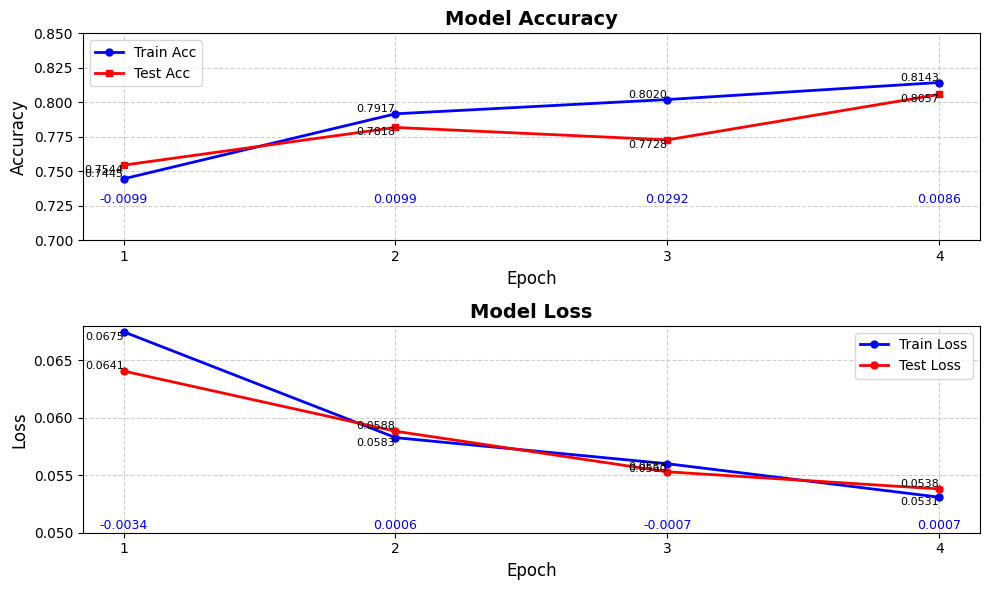

In [ ]:
accuracy = history.history['accuracy'][:4]
val_acc = history.history['val_accuracy'][:4]
loss = history.history['loss'][:4]
val_loss = history.history['val_loss'][:4]

epochs = range(1, len(accuracy) + 1)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

# Plotting the Accuracy Curve
axes[0].plot(epochs, accuracy, 'bo-', label='Train Acc', linewidth=2, markersize=5)  
axes[0].plot(epochs, val_acc, 'rs-', label='Test Acc', linewidth=2, markersize=5)  
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=10)

# backgroud column grid
axes[0].grid(True, linestyle='--', alpha=0.6)

for i in range(len(accuracy)):
    axes[0].text(epochs[i], accuracy[i], f"{accuracy[i]:.4f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[0].text(epochs[i], val_acc[i], f"{val_acc[i]:.4f}", ha='right', va='top', fontsize=8, color='black')

# Plotting the Loss Curve
axes[1].plot(epochs, loss, 'bo-', label='Train Loss', linewidth=2, markersize=5)  
axes[1].plot(epochs, val_loss, 'ro-', label='Test Loss', linewidth=2, markersize=5)  
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.6)

for i in range(len(loss)):
    axes[1].text(epochs[i], loss[i], f"{loss[i]:.4f}", ha='right', va='top', fontsize=8, color='black')
    axes[1].text(epochs[i], val_loss[i], f"{val_loss[i]:.4f}", ha='right', va='bottom', fontsize=8, color='black')

axes[0].set_xticks(range(1, len(epochs) + 1, 1)) 
axes[1].set_xticks(range(1, len(epochs) + 1, 1))  

acc_diff = [round(accuracy[i] - val_acc[i], 4) for i in range(len(accuracy))]
loss_diff = [round(val_loss[i] - loss[i] , 4) for i in range(len(loss))]

# Display the difference between Train and Test
for i in range(len(epochs)):
    axes[0].text(epochs[i], min(accuracy) -0.02, f"{acc_diff[i]:.4f}", 
                 ha='center', va='bottom', fontsize=9, color='blue')
    
    axes[1].text(epochs[i], min(loss) -0.003, f"{loss_diff[i]:.4f}", 
                 ha='center', va='bottom', fontsize=9, color='blue')
    
axes[0].set_ylim(0.70, 0.85)
axes[1].set_ylim(0.05, 0.068)

plt.tight_layout()
plt.show()

### ROC-AUC


📌 ROC AUC: 0.8869


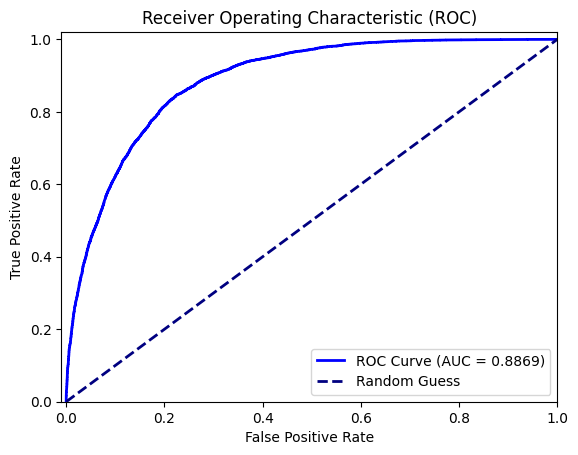

In [19]:
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

print(f"\n📌 ROC AUC: {roc_auc:.4f}")

plt.figure()

plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',label='Random Guess')

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


### PR Curve (precision_recall_curve)


📌 Precision-Recall AUC: 0.7675


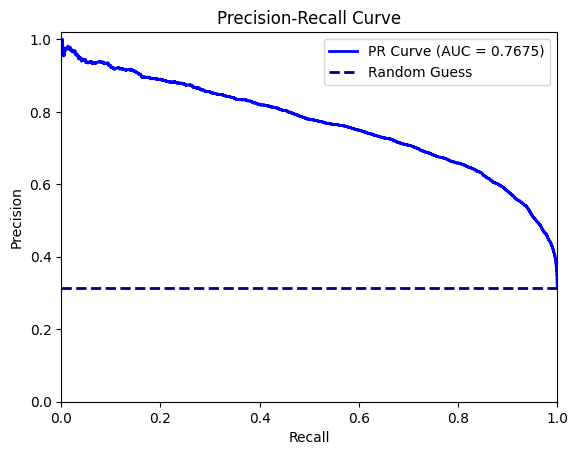

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(Y_test, y_pred_prob)
pr_auc = average_precision_score(Y_test, y_pred_prob)

print(f"\n📌 Precision-Recall AUC: {pr_auc:.4f}")

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')

baseline = sum(Y_test) / len(Y_test)  
plt.plot([0, 1], [baseline, baseline], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


###  Confusion Matrix

False Positive Rate (FPR): 0.1978
False Negative Rate (FNR): 0.1867


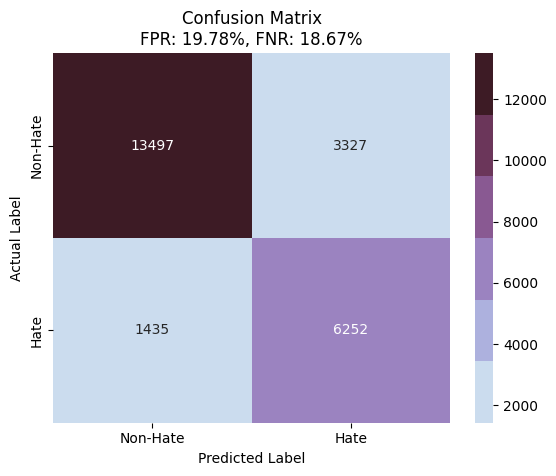

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, y_pred)

TN, FP, FN, TP = cm.ravel()

FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
FNR = FN / (FN + TP) if (FN + TP) > 0 else 0

print(f"False Positive Rate (FPR): {FPR:.4f}")
print(f"False Negative Rate (FNR): {FNR:.4f}")

sns.heatmap(cm, annot=True, fmt="d", cmap=sns.color_palette("ch:start=1,rot=-.5"),
            xticklabels=['Non-Hate', 'Hate'], 
            yticklabels=['Non-Hate', 'Hate'])

plt.xlabel("Predicted Label") 
plt.ylabel("Actual Label")  
plt.title(f"Confusion Matrix\nFPR: {FPR:.2%}, FNR: {FNR:.2%}") 
plt.show()
